### Tracking Covid vaccine rollout in the US

Using data from the Johns Hopkins Centers for Civic Impact we can look at how vaccines are being rolled out across the US.
<br><br>
Looking at a selection of states we can look at completion of the rollout. <b>Not all states</b> are tracking the delineation of first and second doses (such as California) and so for those we can only look at total doses per population.
<br><br>
Let's start by importing our libraries and data

In [1]:
import pandas as pd
import matplotlib
matplotlib.rc('font',size=8)
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

In [2]:
# Get Vaccine data from Johns Hopkins Centers For Civic Impact github (raw csv data location)

vaccine_data_location = "https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/raw_data/vaccine_data_us_state_timeline.csv"
    
vf = pd.read_csv(vaccine_data_location,parse_dates=[0])
vf = vf.pivot_table(columns=['Province_State'],index='date')
cols, states = vf.columns.levels

today = pd.datetime.today().strftime('%Y-%m-%d')
latest_data = vf.index.max().strftime('%Y-%m-%d')
print("Dashboard updated:\t{} \nLatest Data:\t\t{}".format(today,latest_data))

Dashboard updated:	2021-02-08 
Latest Data:		2021-02-08


In [3]:
# pandas import of state pops already exists in my support doc, hidden to protect local file paths
from covid_support import state_info
# Select AZ, CA, ME, NY, OR, TX, WA, WI
state_info = state_info.iloc[[0,1,7,8,9,12,14,15,16]]
state_info['c'] = ['hotpink','b','gold','g','r','c','m','y','k']
shortlist_states = state_info.loc[[1,9,12,14,15]]  # CA NY OR TX WA

#### Look at first and second doses
For the states that are tracking people innoculated with a first and second dose, let's look at the progression in terms of percent of population.
<br><br>
Note that for cases where the data is NA we use the last reported number of doses, i.e. we are not interpolating any progress, and jumps in the data will exist due to either the state's reporting, the data source, or perhaps the state really did give all of those doses in one day.

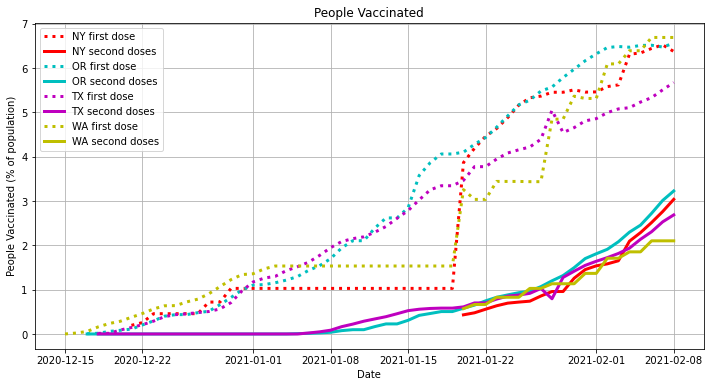

In [4]:
# Total Vaccines vs. Time
# TODO maybe use interpolatin instead of ffill na, but maybe that it is bad to infer any data
plt.figure(figsize=(12,6))
for i,r in shortlist_states.iterrows():
    try:
        vac_per_pop = (vf['people_total',r['State']]/(r['Pop']/1e2)).fillna(method='ffill')
        second_vac_per_pop = (vf['people_total_2nd_dose',r['State']]/(r['Pop']/1e2)).fillna(method='ffill')
        plt.plot(vf.index, vac_per_pop,linewidth=3, label=r['Short']+' first dose',linestyle='dotted',color=r['c'])
        plt.plot(vf.index, second_vac_per_pop,linewidth=3, label=r['Short']+' second doses',linestyle='solid',color=r['c'])
    except KeyError:
        continue    # total people doesnt exist for CA
plt.title('People Vaccinated')
plt.ylabel('People Vaccinated (% of population)')
plt.xlabel('Date')
plt.legend()
plt.grid(which='both')

#### Total doses administered

Given that California and some other states seem to not report a delineation in first/second doses, let's just look at total doses administered vs. % of population.
<br><br>
Note here that the goal of total vaccination would then be a 200%, assuming that all vaccines require a 2 dose application (currently we are not administering vaccines that only have one dose, but this will soon change).
<br>
Also note that there will probably be cases where someone misses their second dose. If this means that someone then has to get 2 more doses, a full vaccination will look like more than 200% doses administered here.

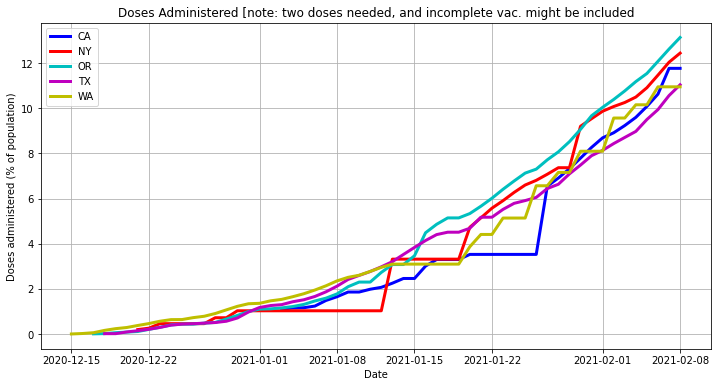

In [5]:
plt.figure(figsize=(12,6))
for i,r in shortlist_states.iterrows():
    try:
        dose_per_pop = (vf['doses_admin_total',r['State']]/(r['Pop']/1e2)).fillna(method='ffill')
        plt.plot(vf.index, dose_per_pop,linewidth=3, label=r['Short'],linestyle='solid',color=r['c'])
    except KeyError:
        print(r['State']+" not plotted")
        continue    # total people doesnt exist for CA
plt.title('Doses Administered [note: two doses needed, and incomplete vac. might be included')
plt.ylabel('Doses administered (% of population)')
plt.xlabel('Date')
plt.legend()
plt.grid(which='both')

#### Doses administered per day
Finally, let's look at the rate of vaccinations. Looking at the change in values of doses administered we can infer the number of doses adminstered for each day.
<br><br>
The scattered values will show raw values of change for each date, and then a line of 7d average will give us an idea of the weekly trends.
<br><br>
Data normalized to percent of population for comparison.

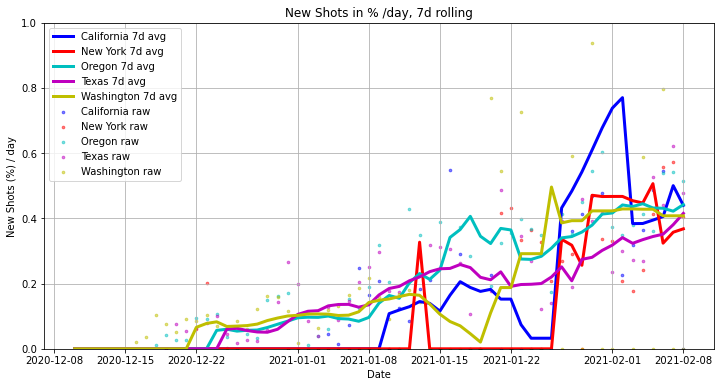

In [6]:
# New Shots per day normalized
plt.figure(figsize=(12,6))
for i,r in shortlist_states.iterrows():
    new_shots_per_pop = (vf['doses_admin_total',r['State']]/(r['Pop']/1e2)).diff().rolling(7).mean().fillna(0)
    plt.scatter(vf.index, (vf['doses_admin_total',r['State']]/(r['Pop']/1e2)).diff(),color=r['c'],s=7,alpha=0.5,label=r['State']+' raw')
    plt.plot(vf.index, new_shots_per_pop,linewidth=3, label=r['State']+' 7d avg',color=r['c'])
plt.title('New Shots in % /day, 7d rolling')
plt.ylabel('New Shots (%) / day')
plt.xlabel('Date')
plt.ylim(0,1)
plt.legend()
plt.grid(which='both')